**Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

**Generate Dummy Data**

Simulating a dataset for loans with richer features.

In [ ]:
np.random.seed(42)
n_samples = 10000

data = pd.DataFrame({
    'loan_id': range(1, n_samples + 1),
    'income': np.random.normal(50000, 15000, n_samples),
    'age': np.random.randint(21, 70, n_samples),
    'loan_amount': np.random.normal(15000, 5000, n_samples),
    'loan_term': np.random.choice([12, 24, 36, 48, 60], n_samples),
    'credit_score': np.random.randint(300, 850, n_samples),
    'num_of_dependents': np.random.randint(0, 5, n_samples),
    'employment_years': np.random.randint(0, 40, n_samples),
    'home_ownership': np.random.choice(['rent', 'own', 'mortgage', 'other'], n_samples),
})

# Simulate default
data['default'] = np.where(
    (data['credit_score'] < 600) & (data['loan_amount'] > 20000), 1, 0
)
data['default'] = np.where(np.random.rand(n_samples) < 0.05, 1, data['default'])
data['default'] = data['default'].astype(int)


**Feature Engineering**

In [ ]:
#Derived Features

data['income_to_loan_ratio'] = data['income'] / data['loan_amount']
data['age_group'] = pd.cut(data['age'], bins=[20, 30, 40, 50, 60, 70], labels=False)
data['loan_to_term_ratio'] = data['loan_amount'] / data['loan_term']
data['employment_to_age_ratio'] = data['employment_years'] / data['age']

#Encode Categorical Features

cat_features = ['home_ownership']
num_features = ['income', 'age', 'loan_amount', 'loan_term', 'credit_score',
                'num_of_dependents', 'employment_years', 'income_to_loan_ratio',
                'loan_to_term_ratio', 'employment_to_age_ratio', 'age_group']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first'), cat_features)
])


**Probability of Default (PD) Model**

In [ ]:
X = data[num_features + cat_features]
y = data['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pd_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

pd_model.fit(X_train, y_train)

data['PD'] = pd_model.predict_proba(X)[:,1]

# PD Model Evaluation
auc = roc_auc_score(y, data['PD'])
print(f"PD Model AUC: {auc:.4f}")


PD Model AUC: 0.8187


**Loss Given Default (LGD) Model**

In [ ]:
#Simulate LGD

data['LGD'] = np.where(data['default']==1, np.random.uniform(0.2, 0.9, n_samples), 0)

#Train LGD Model for Defaulted Loans

lgd_features = num_features + cat_features
X_lgd = data.loc[data['default']==1, lgd_features]
y_lgd = data.loc[data['default']==1, 'LGD']

lgd_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

lgd_model.fit(X_lgd, y_lgd)

data['LGD_pred'] = lgd_model.predict(X)
data['LGD_pred'] = data['LGD_pred'].clip(0,1)

**Exposure at Default (EAD)**

Assuming EAD = loan amount

In [ ]:
data['EAD'] = data['loan_amount']


**Expected Credit Loss (ECL / EL)**

ECL = PD * LGD * EAD

In [ ]:
data['ECL'] = data['PD'] * data['LGD_pred'] * data['EAD']


**Segmentation and Insights**

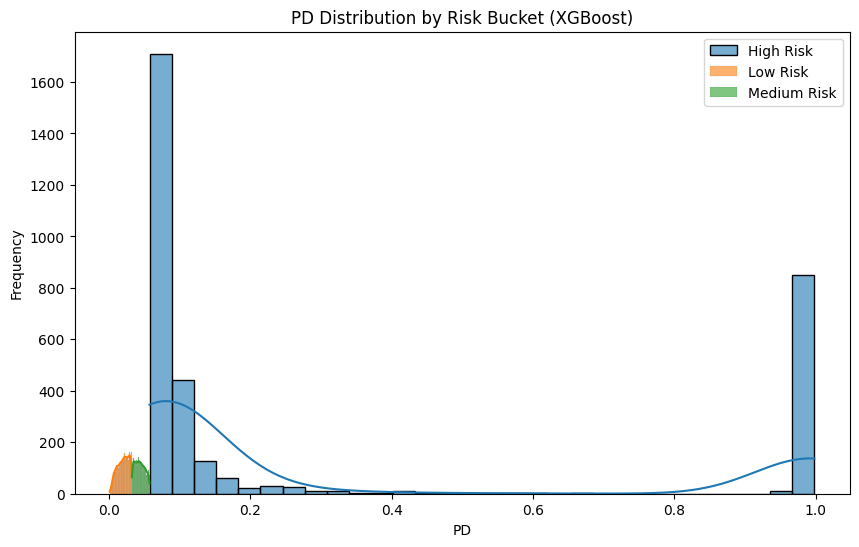

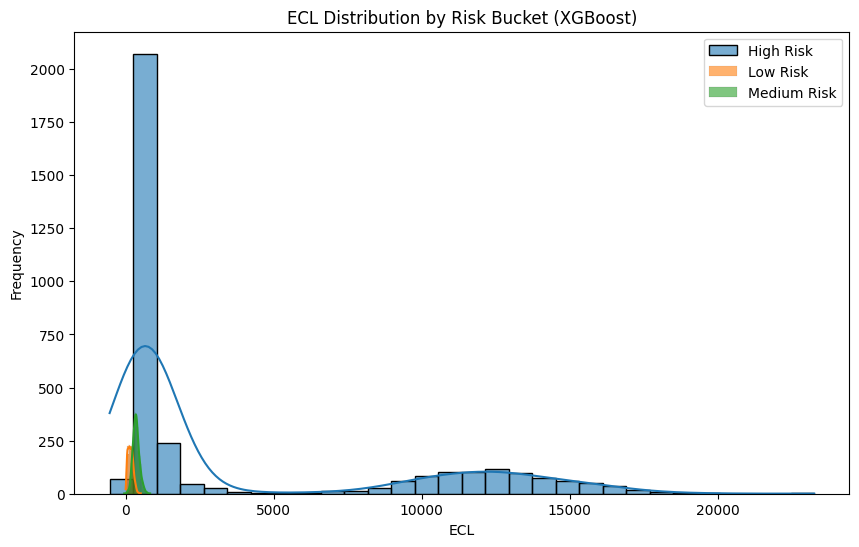

In [ ]:
# Histogram of PD by risk bucket
plt.figure(figsize=(10,6))
for bucket in data['risk_bucket_xgb'].unique():
    subset = data[data['risk_bucket_xgb'] == bucket]
    sns.histplot(subset['PD_xgb'], bins=30, label=f'{bucket} Risk', kde=True, alpha=0.6)
plt.title("PD Distribution by Risk Bucket (XGBoost)")
plt.xlabel("PD")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Histogram of ECL by risk bucket
plt.figure(figsize=(10,6))
for bucket in data['risk_bucket_xgb'].unique():
    subset = data[data['risk_bucket_xgb'] == bucket]
    sns.histplot(subset['ECL_xgb'], bins=30, label=f'{bucket} Risk', kde=True, alpha=0.6)
plt.title("ECL Distribution by Risk Bucket (XGBoost)")
plt.xlabel("ECL")
plt.ylabel("Frequency")
plt.legend()
plt.show()


**Backtesting**

- Compare predicted PD with actual defaults over the population.
- Compute decile-wise default rate vs predicted PD.
- Compute LGD RMSE.

In [ ]:
# PD backtesting
data['PD_decile'] = pd.qcut(data['PD'], 10, labels=False)
backtest = data.groupby('PD_decile')[['default','PD']].agg(['mean','count'])
print(backtest)

# LGD evaluation
lgd_mse = mean_squared_error(data.loc[data['default']==1,'LGD'],
                              data.loc[data['default']==1,'LGD_pred'])
lgd_rmse = np.sqrt(lgd_mse)
print(f"LGD RMSE: {lgd_rmse:.4f}")

          default              PD      
             mean count      mean count
PD_decile                              
0           0.041  1000  0.004529  1000
1           0.055  1000  0.012028  1000
2           0.054  1000  0.021498  1000
3           0.043  1000  0.034583  1000
4           0.054  1000  0.052533  1000
5           0.050  1000  0.077960  1000
6           0.064  1000  0.115943  1000
7           0.044  1000  0.172520  1000
8           0.180  1000  0.279768  1000
9           0.739  1000  0.546586  1000
LGD RMSE: 0.0768


**Advanced PD & LGD Modeling with XGBoost**

In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, mean_squared_error

# Prepare data
X = data[num_features + cat_features]
y_pd = data['default']
X_train, X_test, y_train, y_test = train_test_split(X, y_pd, test_size=0.3, random_state=42)

# Preprocessing for categorical variables
X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc = pd.get_dummies(X_test, drop_first=True)

# Align columns
X_test_enc = X_test_enc.reindex(columns = X_train_enc.columns, fill_value=0)

# XGBoost Classifier for PD
pd_model_xgb = xgb.XGBClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42
)
pd_model_xgb.fit(X_train_enc, y_train)

# Predict PD
data['PD_xgb'] = pd_model_xgb.predict_proba(pd.get_dummies(X, drop_first=True))[:,1]

# Evaluate
auc_xgb = roc_auc_score(y_pd, data['PD_xgb'])
print(f"XGBoost PD Model AUC: {auc_xgb:.4f}")


XGBoost PD Model AUC: 0.9379


**LGD Model Using XGBoost Regressor**

In [ ]:
# Use only defaulted loans for LGD
lgd_data = data[data['default']==1]
X_lgd = pd.get_dummies(lgd_data[num_features + cat_features], drop_first=True)
y_lgd = lgd_data['LGD']

lgd_model_xgb = xgb.XGBRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42
)
lgd_model_xgb.fit(X_lgd, y_lgd)

# Predict LGD for all loans
X_all_enc = pd.get_dummies(data[num_features + cat_features], drop_first=True)
X_all_enc = X_all_enc.reindex(columns=X_lgd.columns, fill_value=0)

data['LGD_xgb'] = lgd_model_xgb.predict(X_all_enc).clip(0,1)


**Portfolio-Level ECL Reporting**

ECL = PD * LGD * EAD

In [ ]:
data['ECL_xgb'] = data['PD_xgb'] * data['LGD_xgb'] * data['loan_amount']

# Portfolio-level summary
portfolio_summary = data[['ECL_xgb','PD_xgb','LGD_xgb','loan_amount']].agg(['sum','mean'])
print(portfolio_summary)


           ECL_xgb       PD_xgb      LGD_xgb   loan_amount
sum   1.433371e+07  1298.423096  5555.208008  1.502763e+08
mean  1.433371e+03     0.129842     0.555521  1.502763e+04


**Stress Testing Scenarios**

Simulate economic stress where defaults increase by 20% and LGD increases by 15%.

In [ ]:
stress_PD = (data['PD_xgb'] * 1.2).clip(0,1)
stress_LGD = (data['LGD_xgb'] * 1.15).clip(0,1)

data['ECL_stress'] = stress_PD * stress_LGD * data['loan_amount']

# Compare portfolio ECL
total_ecl_normal = data['ECL_xgb'].sum()
total_ecl_stress = data['ECL_stress'].sum()

print(f"Total ECL (Normal): ${total_ecl_normal:,.2f}")
print(f"Total ECL (Stress): ${total_ecl_stress:,.2f}")
print(f"ECL Increase under Stress: ${total_ecl_stress - total_ecl_normal:,.2f}")


Total ECL (Normal): $14,333,710.76
Total ECL (Stress): $17,389,368.76
ECL Increase under Stress: $3,055,658.00


**Risk Segmentation & Insights**

In [ ]:
data['risk_bucket_xgb'] = pd.qcut(data['PD_xgb'], q=3, labels=['Low','Medium','High'])

bucket_summary = data.groupby('risk_bucket_xgb')[['PD_xgb','LGD_xgb','ECL_xgb']].mean()
print(bucket_summary)


                   PD_xgb   LGD_xgb      ECL_xgb
risk_bucket_xgb                                 
Low              0.019893  0.551822   157.632972
Medium           0.044008  0.555986   346.666290
High             0.325568  0.558754  3795.105374


/tmp/ipython-input-4145263870.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_summary = data.groupby('risk_bucket_xgb')[['PD_xgb','LGD_xgb','ECL_xgb']].mean()


**Visualizations**

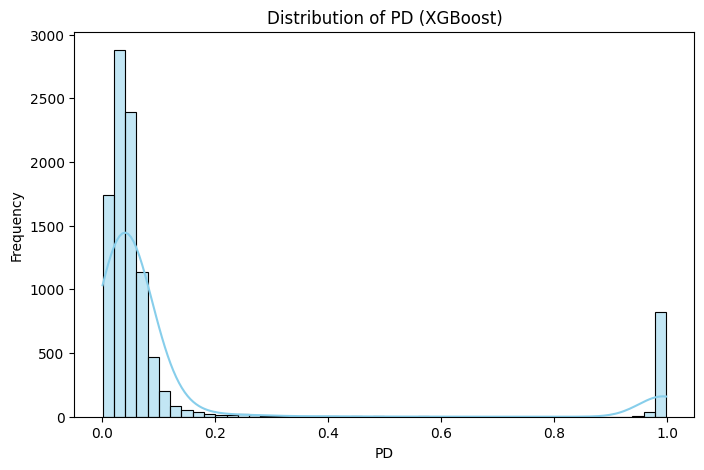

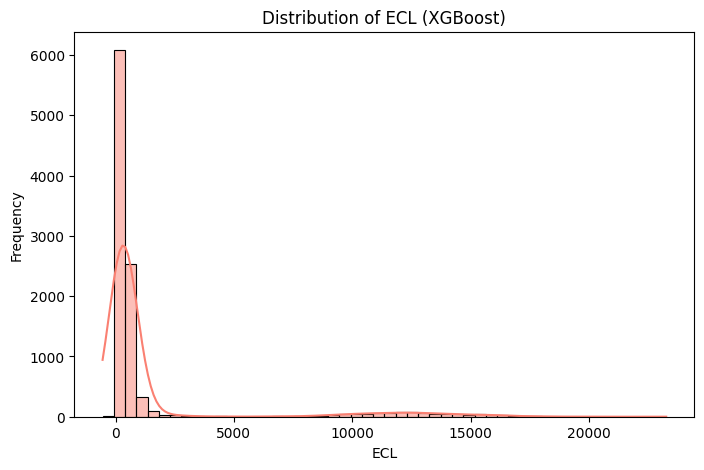

In [ ]:
# Histogram for PD (XGBoost)
plt.figure(figsize=(8,5))
sns.histplot(data['PD_xgb'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of PD (XGBoost)")
plt.xlabel("PD")
plt.ylabel("Frequency")
plt.show()

# Histogram for ECL (XGBoost)
plt.figure(figsize=(8,5))
sns.histplot(data['ECL_xgb'], bins=50, kde=True, color='salmon')
plt.title("Distribution of ECL (XGBoost)")
plt.xlabel("ECL")
plt.ylabel("Frequency")
plt.show()


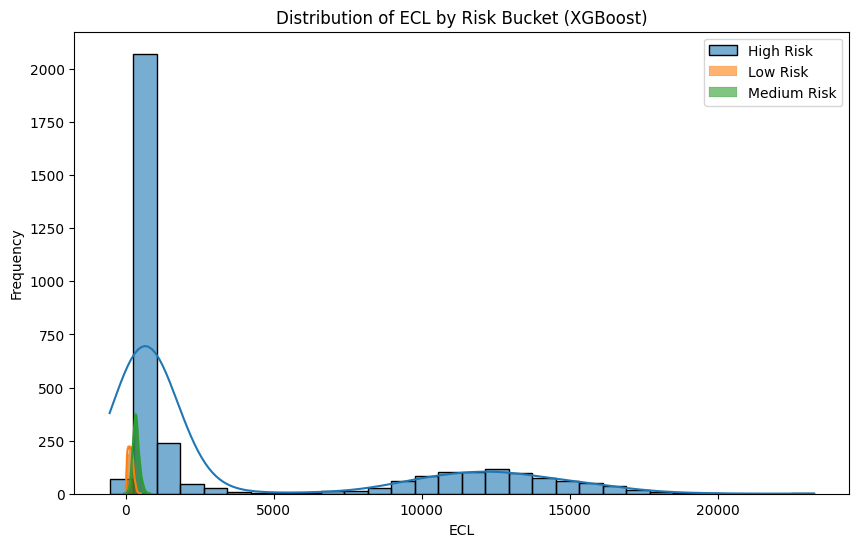

In [ ]:
# Risk buckets: Low, Medium, High
risk_buckets = data['risk_bucket_xgb'].unique()

plt.figure(figsize=(10,6))

for bucket in risk_buckets:
    subset = data[data['risk_bucket_xgb'] == bucket]
    sns.histplot(subset['ECL_xgb'], bins=30, kde=True, label=f'{bucket} Risk', alpha=0.6)

plt.title("Distribution of ECL by Risk Bucket (XGBoost)")
plt.xlabel("ECL")
plt.ylabel("Frequency")
plt.legend()
plt.show()
